In [83]:
import sys
import os
import warnings
import numpy as np
import pandas as pd
from pathlib import Path

In [84]:
# add RealSeries/realseries to sys path
sys.path.append('..')

In [85]:
from realseries.models.lstm_dynamic import LSTM_dynamic
from realseries.utils.evaluation import point_metrics, adjust_metrics
from realseries.utils.visualize import plot_anom
os.environ["CUDA_VISIBLE_DEVICES"] = '7'

In [86]:
# error parameters
# --------------------------
# 处理errors的时候，序列太长需要分批次处理，一个batch的长度就是batch_size，
# window_size是计算异常时候，一次使用多少个点。这个例子中，一个批次是50个点，每次处理10个点计算异常值。
# number of values to evaluate in each batch in the prediction stage
batch_size = 50

# number of trailing batches to use in error calculation
window_size = 10

# determines window size used in EWMA smoothing (percentage of total values for channel)
# 对errors平滑处理，移动平均使用前5%的点计算初始均值
smoothing_perc = 0.05

# number of values surrounding an error that are brought into the sequence (promotes grouping on nearby sequences
#如果一个点被判为异常，那么它相邻的error_buffer个点也被视为异常点。这个值决定了预测出的异常区间的大小，如果预测出的异常区间太大，可以调小
error_buffer = 20

# minimum percent decrease between max errors in anomalous sequences (used for pruning)
p = 0.13

# 对一个errors序列，开始的前l_s*2个点不参与计算anomaly,刚启动的数据可能不适合参与计算，l_s也可以设置为0，即不丢弃开头
l_s=10

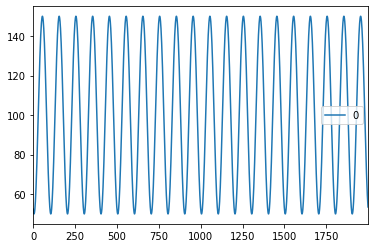

In [87]:
# gen y_test and y_hat data
n = 2000
A = 50
center = 100
phi = 30
T = 2 * np.pi / 100
t = np.arange(n)
y_test = A * np.sin(T * t - phi * T) + center
y_test = y_test[:,None]  # y必须是二维的（n_samples,1）
pd.DataFrame(y_test).plot()

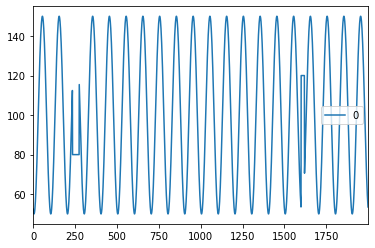

In [88]:
y_hat = y_test.copy()
y_hat[235:275] = 80
y_hat[1600:1620] = 120
pd.DataFrame(y_hat).plot()

#
label = np.zeros(len(y_test))
label[235:275] = 1
label[1600:1620] = 1

In [89]:
anomaly, score = LSTM_dynamic.obtain_anomaly(
    y_test, 
    y_hat, 
    batch_size,
    window_size,
    smoothing_perc,  
    p,
    l_s,
    error_buffer)

error_seq: [(230, 297), (1600, 1646)], error_seq_scores: [5.625099194065446, 4.729638429386673]


In [90]:
# create anomaly score array for ploting and evaluation
pred_anom = np.zeros(len(y_test))
pred_score = np.zeros(len(y_test))
for (l, r), score_ in zip(anomaly, score):
    pred_anom[l:r] = 1
    pred_score[l:r] = score_

In [91]:
test_set = pd.DataFrame({'value':y_test[:,0],'label':label})

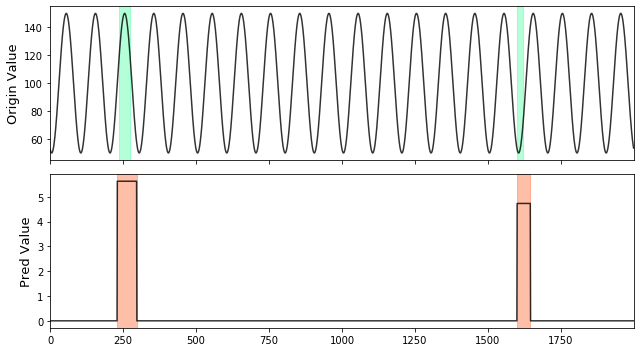

In [92]:
plot_anom(
    test_set,
    pred_anom,
    pred_score)